In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import display
import seaborn as sns

In [3]:
def min_max_norm(v):
    return (v - v.min()) / (v.max() - v.min())

In [30]:
# Segment each controlled trial run

fft = pd.read_csv('data/diego-controlled-runs/grafana_data_export oct_fftcb.csv', sep=';', engine='python', header=1)
fft['Time'] = pd.to_datetime(fft['Time'])
fft.reset_index(inplace=True, drop=True)

def get_run_code(data, start, end, condition, pressure, stiffener_kit, display=False):
    
    if display:
        figure(figsize=(20, 6), dpi=80)
        plt.scatter(x=data.iloc[start:end, :].index, 
                    y=data.iloc[start:end, :]['Value'], alpha=.7, s=5)
        plt.ylabel('FFT')
        plt.show()

    df = data.iloc[start:end, :].reset_index(drop=True)
    df['condition'] = condition
    df['pressure'] = pressure
    df['stiffener kit'] = stiffener_kit
    return df

# The run codes have to be found by index because the times are messed up
CB_FFT_Band3_B1 = get_run_code(fft[fft['Series'] == 'CB FFT Band 3'].reset_index(drop=True), 1920, 2750, 'Target', 2.3, True)
CB_FFT_Band3_B2 = get_run_code(fft[fft['Series'] == 'CB FFT Band 3'].reset_index(drop=True), 3650, 4500, 'Low', 1.8, True)
CB_FFT_Band3_B3 = get_run_code(fft[fft['Series'] == 'CB FFT Band 3'].reset_index(drop=True), 6610, 7430, 'Ultra Low', 1.4, True)
CB_FFT_Band3_A1 = get_run_code(fft[fft['Series'] == 'CB FFT Band 3'].reset_index(drop=True), 23292, 23483, 'Target', 3.4, False)
CB_FFT_Band3_A2 = get_run_code(fft[fft['Series'] == 'CB FFT Band 3'].reset_index(drop=True), 24098, 24780, 'Low', 2.7, False)
CB_FFT_Band3_A3 = get_run_code(fft[fft['Series'] == 'CB FFT Band 3'].reset_index(drop=True), 24843, 25342, 'Low', 2.0, False)
CB_FFT_Band3_A4 = get_run_code(fft[fft['Series'] == 'CB FFT Band 3'].reset_index(drop=True), 25666, 26280, 'Target', 3.4, False)
CB_FFT_Band3_A5 = get_run_code(fft[fft['Series'] == 'CB FFT Band 3'].reset_index(drop=True), 26560, 26684, 'High', 4.0, False)

In [34]:
domingo_band3_new_equip = pd.concat([CB_FFT_Band3_B1, CB_FFT_Band3_B2, CB_FFT_Band3_B3])
domingo_band3_new_equip = domingo_band3_new_equip.rename(columns={'Value': 'FFT'})
domingo_band3_new_equip = domingo_band3_new_equip.reset_index(drop=True)

domingo_band3_old_equip = pd.concat([CB_FFT_Band3_A1, CB_FFT_Band3_A2, CB_FFT_Band3_A3, CB_FFT_Band3_A4, CB_FFT_Band3_A5])
domingo_band3_old_equip = domingo_band3_old_equip.rename(columns={'Value': 'FFT'})
domingo_band3_old_equip = domingo_band3_old_equip.reset_index(drop=True)

# Combine all trials into one DF
domingo_band3 = pd.concat([domingo_band3_new_equip, domingo_band3_old_equip])
domingo_band3 = domingo_band3.reset_index(drop=True)
domingo_band3
# domingo_band3.to_csv('data/reformated/diego-controlled-oct-fftcb-band3.csv')

Series                      Time       FFT condition  pressure  \
0     CB FFT Band 3 2021-06-21 09:25:30+02:00  0.402173    Target       2.3   
1     CB FFT Band 3 2021-06-21 09:25:30+02:00  0.434493    Target       2.3   
2     CB FFT Band 3 2021-06-21 09:25:30+02:00  0.437564    Target       2.3   
3     CB FFT Band 3 2021-06-21 09:25:30+02:00  0.265910    Target       2.3   
4     CB FFT Band 3 2021-06-21 09:25:30+02:00  0.347339    Target       2.3   
...             ...                       ...       ...       ...       ...   
4605  CB FFT Band 3 2021-06-21 16:36:50+02:00  0.195899      High       4.0   
4606  CB FFT Band 3 2021-06-21 16:36:50+02:00  0.209436      High       4.0   
4607  CB FFT Band 3 2021-06-21 16:36:50+02:00  0.205936      High       4.0   
4608  CB FFT Band 3 2021-06-21 16:36:50+02:00  0.190878      High       4.0   
4609  CB FFT Band 3 2021-06-21 16:36:50+02:00  0.156201      High       4.0   

      stiffener kit  
0              True  
1              True  
2              True  
3              True  
4              True  
...             ...  
4605          False  
4606          False  
4607          False  
4608          False  
4609          False  

[4610 rows x 6 columns]

Text(0, 0.5, 'FFT')

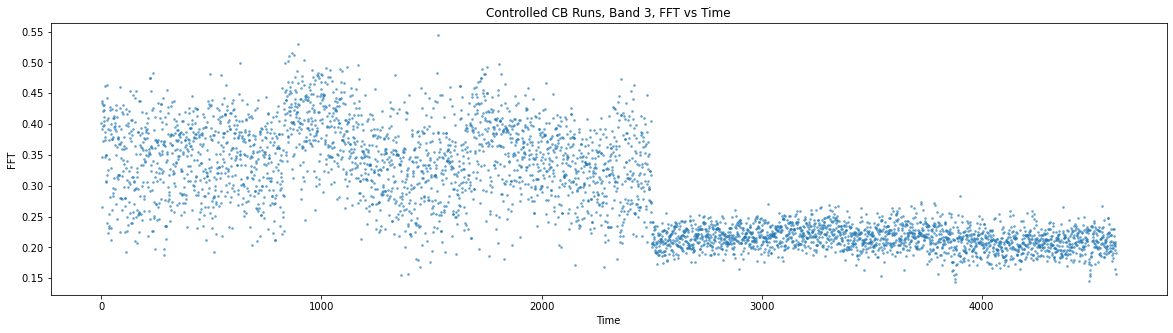

In [6]:
figure(figsize=(20,5))
plt.scatter(domingo_band3.index, domingo_band3['FFT'], s=3, alpha=.5)
plt.title('Controlled CB Runs, Band 3, FFT vs Time')
plt.xlabel('Time')
plt.ylabel('FFT')

In [7]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

def silhouette_cluster_analysis(data, df, algorithm='hac'):
    range_n_clusters = np.arange(2,12)

    best_clustering = None
    best_sil_avg = 0

    for n_clusters in range_n_clusters:

        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

        if algorithm == 'kmeans':
            clustering = KMeans(n_clusters=n_clusters).fit( data )
        if algorithm == 'hac':
            clustering = AgglomerativeClustering(n_clusters=n_clusters).fit( data )
        labels = clustering.labels_
        df['Labels'] = labels

        silhouette_avg = silhouette_score(data, labels)

        if silhouette_avg > best_sil_avg:
            best_sil_avg = silhouette_avg
            best_clustering = clustering

        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(data, labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(labels.astype(float) / n_clusters)
        ax2.scatter(
            df.index, df.FFT, marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
        )

        # # Labeling the clusters
        # centers = clustering.cluster_centers_
        # # Draw white circles at cluster centers
        # ax2.scatter(
        #     centers[:, 0],
        #     centers[:, 1],
        #     marker="o",
        #     c="white",
        #     alpha=1,
        #     s=200,
        #     edgecolor="k",
        # )

        # for i, c in enumerate(centers):
        #     ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(
            "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

    plt.show()
    return best_clustering

        FFT  pressure  stiffener kit  condition_High  condition_Low  \
0  0.402173       2.3              1               0              0   
1  0.434493       2.3              1               0              0   
2  0.437564       2.3              1               0              0   
3  0.265910       2.3              1               0              0   
4  0.347339       2.3              1               0              0   

   condition_Target  condition_Ultra Low  
0                 1                    0  
1                 1                    0  
2                 1                    0  
3                 1                    0  
4                 1                    0  
[[0.06713381 0.55921379 1.         ... 0.         1.         0.        ]
 [0.07551394 0.55921379 1.         ... 0.         1.         0.        ]
 [0.0763102  0.55921379 1.         ... 0.         1.         0.        ]
 ...
 [0.01625231 1.         0.         ... 0.         0.         0.        ]
 [0.01234798 1.   

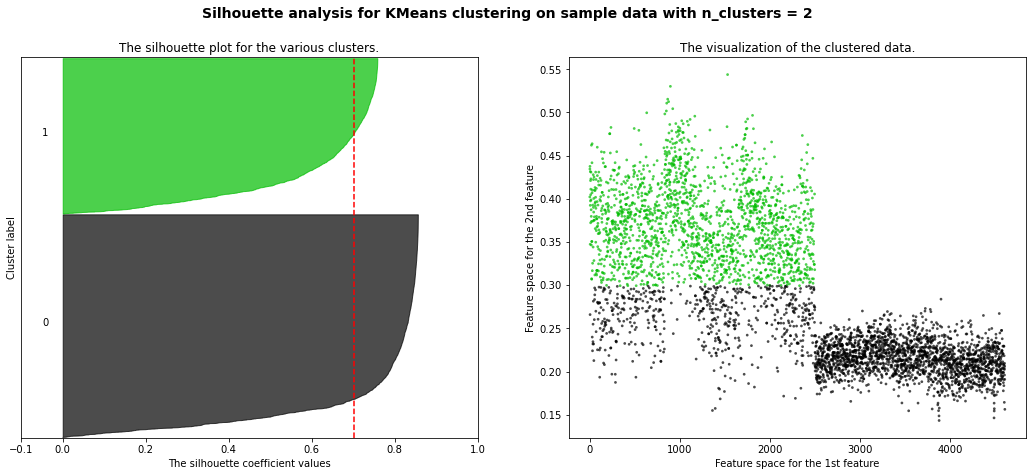

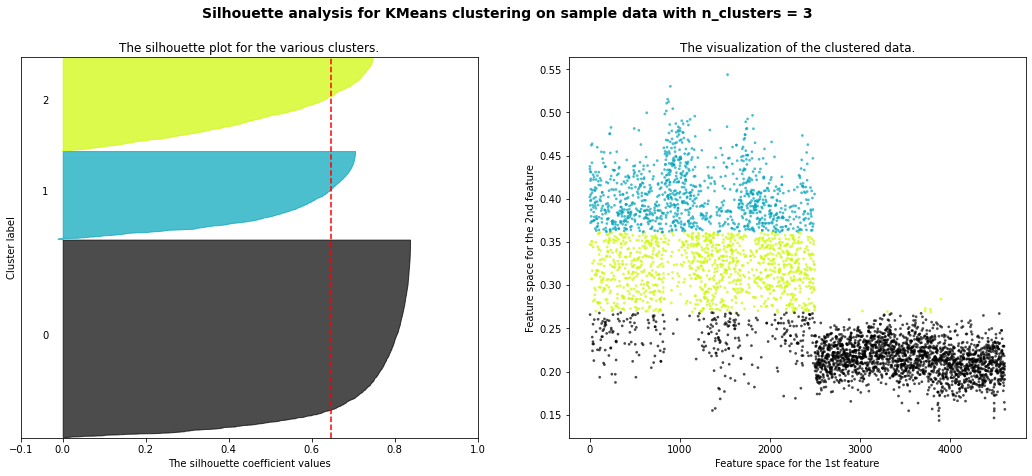

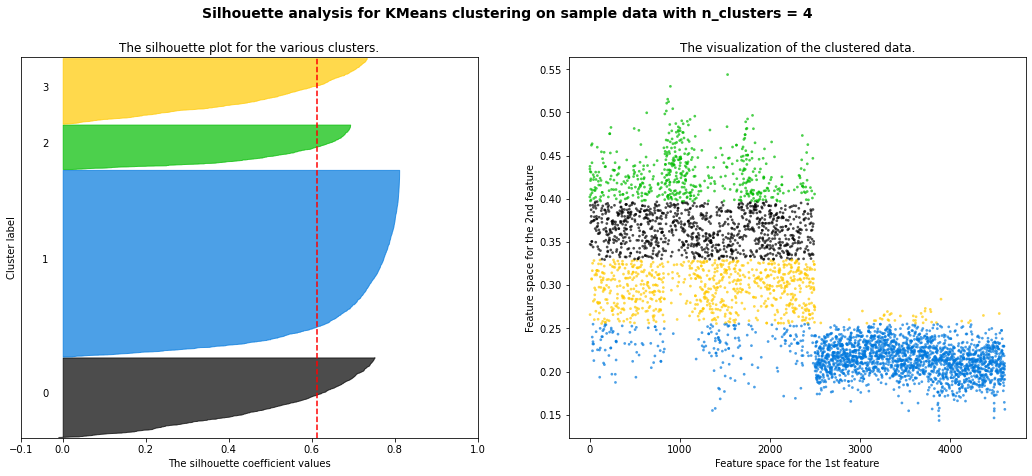

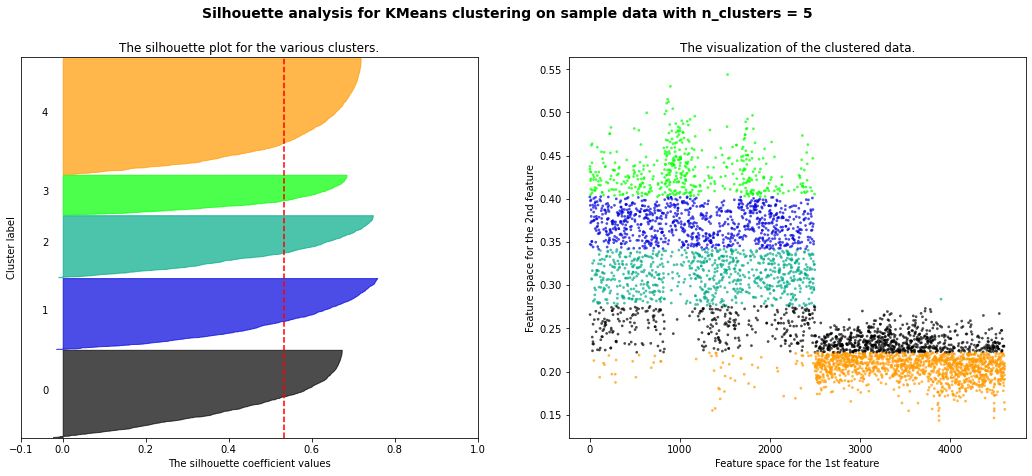

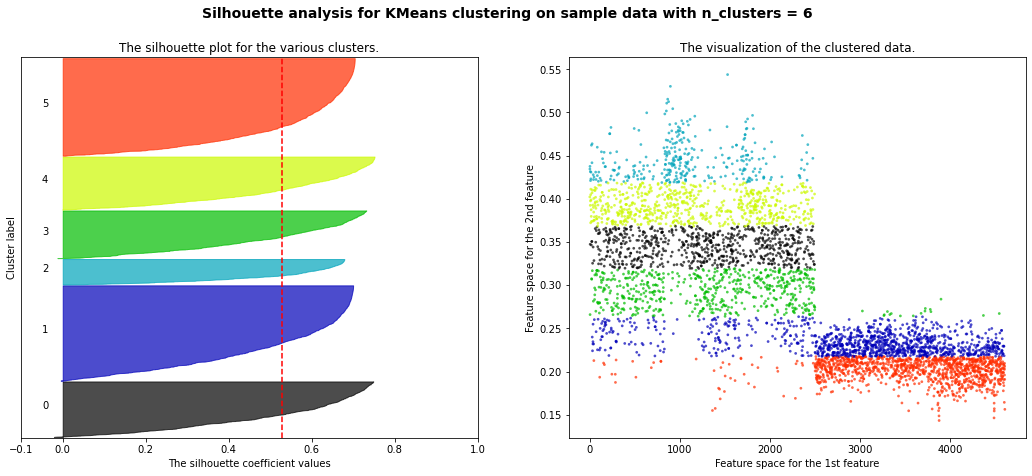

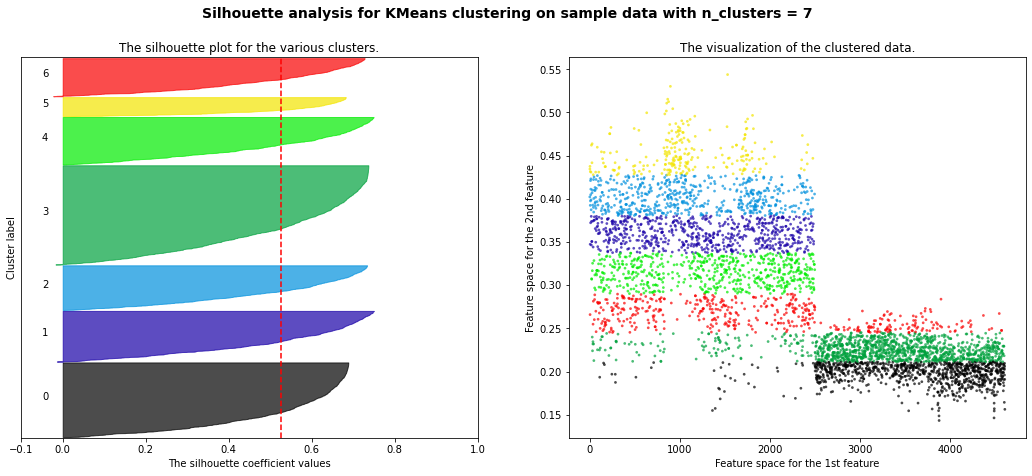

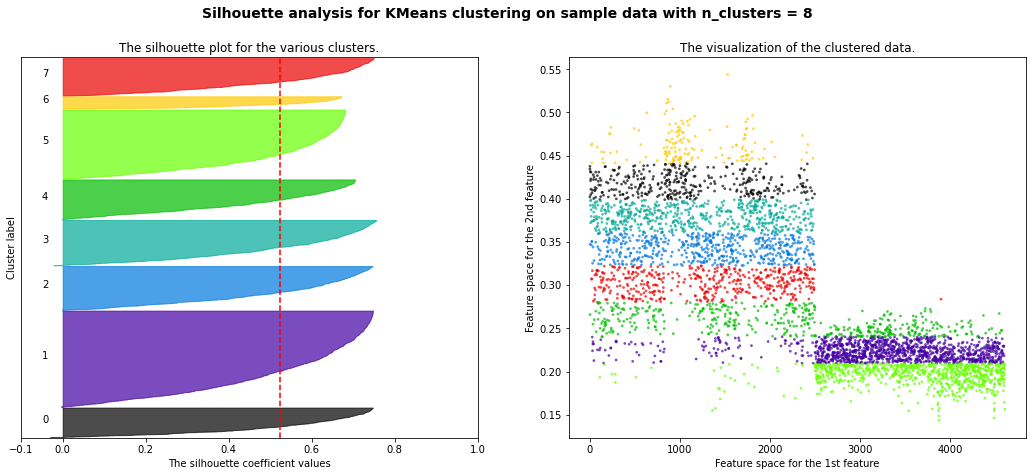

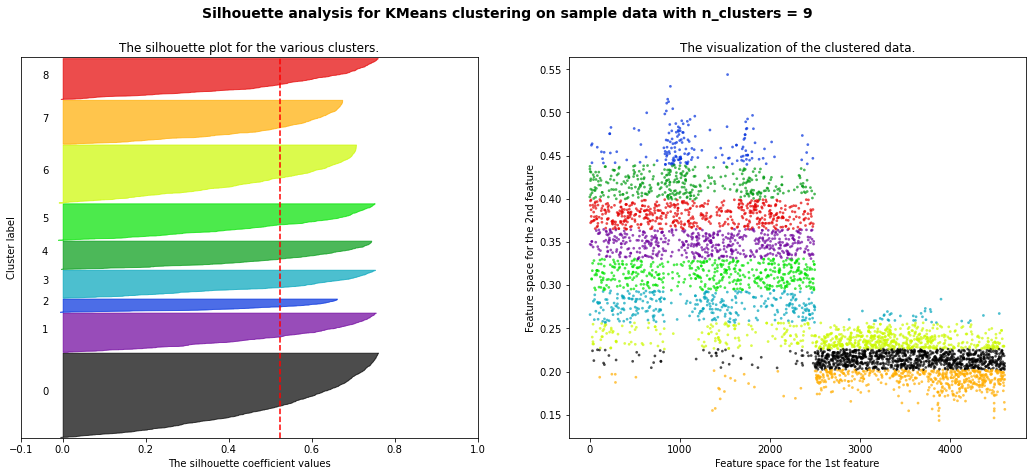

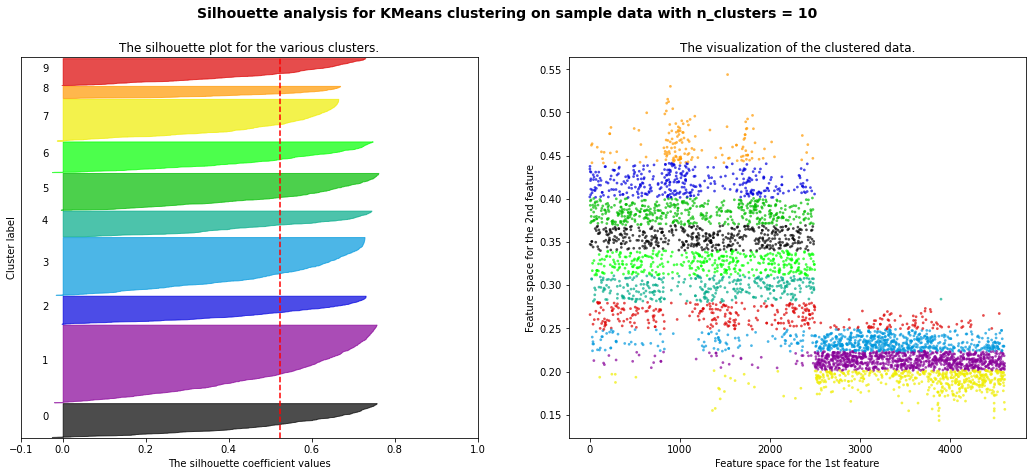

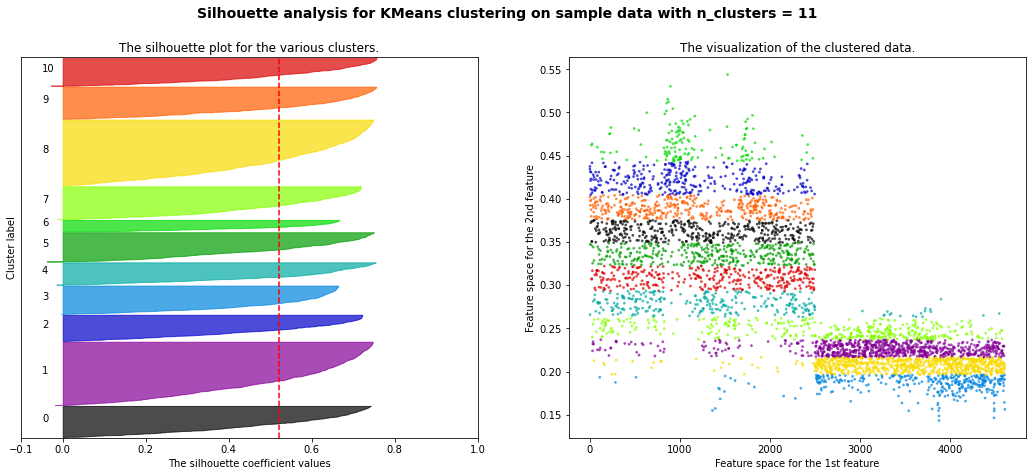

In [8]:
controlled_fft_cluster_df = domingo_band3.drop(columns=['Series', 'Time'])
# controlled_fft_cluster_df['condition'] = controlled_fft_cluster_df['condition'].map({'Ultra Low': 0,
#                                        'Low': 1,
#                                        'Target': 2,
#                                        'High': 3,
#                                        'Ultra High': 4})
controlled_fft_cluster_df = pd.get_dummies(controlled_fft_cluster_df)
controlled_fft_cluster_df['stiffener kit'] = controlled_fft_cluster_df['stiffener kit'].astype(int)
print(controlled_fft_cluster_df.head())

controlled_fft_pressures = np.array(controlled_fft_cluster_df.pressure)

controlled_fft_cluster_data = controlled_fft_cluster_df.to_numpy()

# Normalize FFT and Pressure
controlled_fft_cluster_data[:, :2] = min_max_norm(controlled_fft_cluster_data[:, :2])
print(controlled_fft_cluster_data)

# Perform clustering
# controlled_fft_best_clustering = silhouette_cluster_analysis(controlled_fft_cluster_data, controlled_fft_cluster_df, 'kmeans')
controlled_fft_best_clustering = silhouette_cluster_analysis(controlled_fft_cluster_data[:, :1], controlled_fft_cluster_df, 'kmeans')

FFT  pressure  stiffener kit  condition_High  condition_Low  \
0  0.402173       2.3              1               0              0   
1  0.434493       2.3              1               0              0   
2  0.437564       2.3              1               0              0   
3  0.265910       2.3              1               0              0   
4  0.347339       2.3              1               0              0   

   condition_Target  condition_Ultra Low  Labels  
0                 1                    0       9  
1                 1                    0       2  
2                 1                    0       2  
3                 1                    0       4  
4                 1                    0       5

Series                      Time       FFT condition  pressure  \
0  CB FFT Band 3 2021-06-21 09:25:30+02:00  0.402173    Target       2.3   
1  CB FFT Band 3 2021-06-21 09:25:30+02:00  0.434493    Target       2.3   
2  CB FFT Band 3 2021-06-21 09:25:30+02:00  0.437564    Target       2.3   
3  CB FFT Band 3 2021-06-21 09:25:30+02:00  0.265910    Target       2.3   
4  CB FFT Band 3 2021-06-21 09:25:30+02:00  0.347339    Target       2.3   

   stiffener kit  
0           True  
1           True  
2           True  
3           True  
4           True

[[0.06713381 0.55921379 1.         ... 0.         1.         0.        ]
 [0.07551394 0.55921379 1.         ... 0.         1.         0.        ]
 [0.0763102  0.55921379 1.         ... 0.         1.         0.        ]
 ...
 [0.01625231 1.         0.         ... 0.         0.         0.        ]
 [0.01234798 1.         0.         ... 0.         0.         0.        ]
 [0.00335672 1.         0.         ... 0.         0.         0.        ]]
[-0.0052345  -0.00581048 -0.00586521 ...  0.4380065   0.43827486
  0.43889284]
[0.99192063]


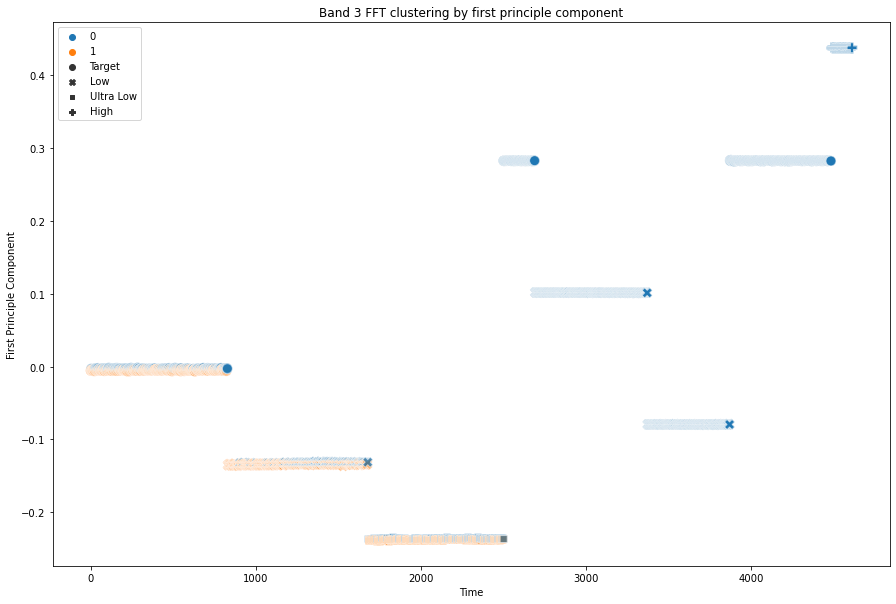

In [10]:
# # PCA visualization
# from sklearn.decomposition import PCA
# display(controlled_fft_cluster_df.head())
# display(domingo_band3.head())
# print(controlled_fft_cluster_data)

# pca = PCA(n_components=1)
# first_pc = pca.fit_transform(controlled_fft_cluster_data[:, :2]).reshape(-1)
# print(first_pc)
# print(pca.explained_variance_ratio_)

# figure(figsize=(15,10))
# start, end = 0, len(first_pc)
# sns.scatterplot(x=controlled_fft_cluster_df.index[start:end],
#                 y=first_pc[start:end],
#                 hue=controlled_fft_best_clustering.labels_[start:end],
#                 style=domingo_band3.condition.iloc[start:end],
#                 palette=sns.color_palette( n_colors=len(np.unique(controlled_fft_best_clustering.labels_[start:end]))),
#                 s=100, alpha=.5)
# plt.title('Band 3 FFT clustering by first principle component')
# plt.xlabel('Time')
# plt.ylabel('First Principle Component')
# plt.legend()

C:\Users\camer\anaconda3\envs\general\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\camer\anaconda3\envs\general\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'FFT Band3')

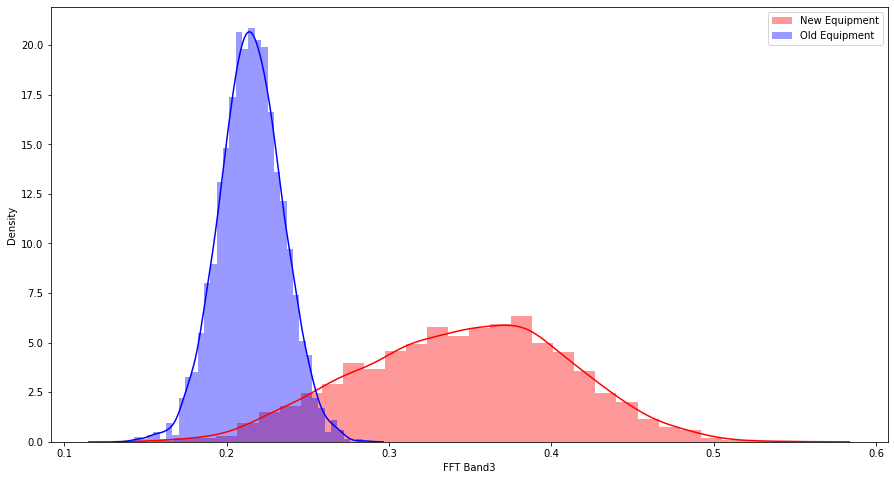

In [48]:
figure(figsize=(15,8))

len_new = len(domingo_band3_new_equip)
len_old = len(domingo_band3_old_equip)

sns.distplot(domingo_band3_new_equip.FFT, color='r', label='New Equipment')
sns.distplot(domingo_band3_old_equip.FFT, color='b', label='Old Equipment')
plt.legend()
plt.xlabel('FFT Band3')

In [11]:
oct_overall = pd.read_csv('data/diego-controlled-runs/grafana_data_export oct_overall.csv', sep=';', engine='python', header=1)
oct_overall = oct_overall[oct_overall['Series'] == 'CB Bond Vibration'].reset_index(drop=True)
oct_overall_cb = oct_overall.drop(columns='Series')

CB_RMS_OVERALL_B1 = get_run_code(oct_overall_cb, 11700, 16700, 'Target', 2.3, True)
CB_RMS_OVERALL_B2 = get_run_code(oct_overall_cb, 23000, 28050, 'Low', 1.8, True)
CB_RMS_OVERALL_B3 = get_run_code(oct_overall_cb, 42790, 47700, 'Ultra Low', 1.4, True)
CB_RMS_OVERALL_A1 = get_run_code(oct_overall_cb, 123820, 125100, 'Target', 3.4, False)
CB_RMS_OVERALL_A2 = get_run_code(oct_overall_cb, 130110, 135045, 'Low', 2.7, False)
CB_RMS_OVERALL_A3 = get_run_code(oct_overall_cb, 135270, 139175, 'Low', 2.0, False)
CB_RMS_OVERALL_A4 = get_run_code(oct_overall_cb, 141880, 146164, 'Target', 3.4, False)
CB_RMS_OVERALL_A5 = get_run_code(oct_overall_cb, 148498, 149249, 'High', 4.0, False)

Time       FFT condition  pressure  stiffener kit
0      2021-06-21T09:25:29+02:00  0.015388    Target       2.3           True
1      2021-06-21T09:25:29+02:00  0.016388    Target       2.3           True
2      2021-06-21T09:25:29+02:00  0.016388    Target       2.3           True
3      2021-06-21T09:25:29+02:00  0.016678    Target       2.3           True
4      2021-06-21T09:25:29+02:00  0.016678    Target       2.3           True
...                          ...       ...       ...       ...            ...
30110  2021-06-21T16:36:56+02:00  0.011262      High       4.0          False
30111  2021-06-21T16:36:56+02:00  0.011262      High       4.0          False
30112  2021-06-21T16:36:56+02:00  0.011262      High       4.0          False
30113  2021-06-21T16:36:56+02:00  0.011262      High       4.0          False
30114  2021-06-21T16:36:56+02:00  0.010736      High       4.0          False

[30115 rows x 5 columns]

FFT  pressure  stiffener kit  condition_High  condition_Low  \
0  0.015388       2.3              1               0              0   
1  0.016388       2.3              1               0              0   
2  0.016388       2.3              1               0              0   
3  0.016678       2.3              1               0              0   
4  0.016678       2.3              1               0              0   

   condition_Target  condition_Ultra Low  
0                 1                    0  
1                 1                    0  
2                 1                    0  
3                 1                    0  
4                 1                    0

[[1.37330174e-03 5.73944638e-01 1.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [1.62405412e-03 5.73944638e-01 1.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [1.62405412e-03 5.73944638e-01 1.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 ...
 [3.39375025e-04 1.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.39375025e-04 1.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.07520289e-04 1.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
For n_clusters = 2 The average silhouette_score is : 0.5453792634270903
For n_clusters = 3 The average silhouette_score is : 0.5186516683177218
For n_clusters = 4 The average silhouette_score is : 0.5239503269073106
For n_clusters = 5 The average silhouette_score is : 0.524698722779227
For n_clusters = 6 The average silhouette_score is : 0.5236162268795475
For n_clusters = 7 The average silhouette

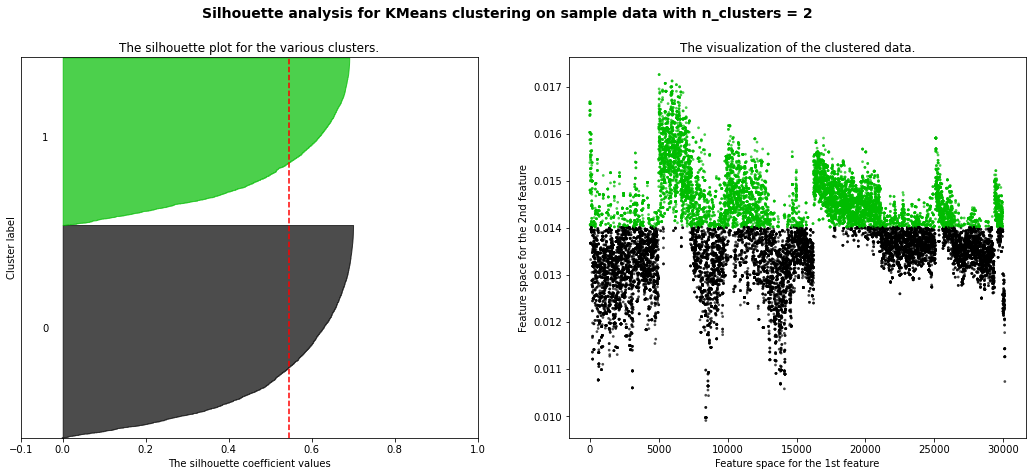

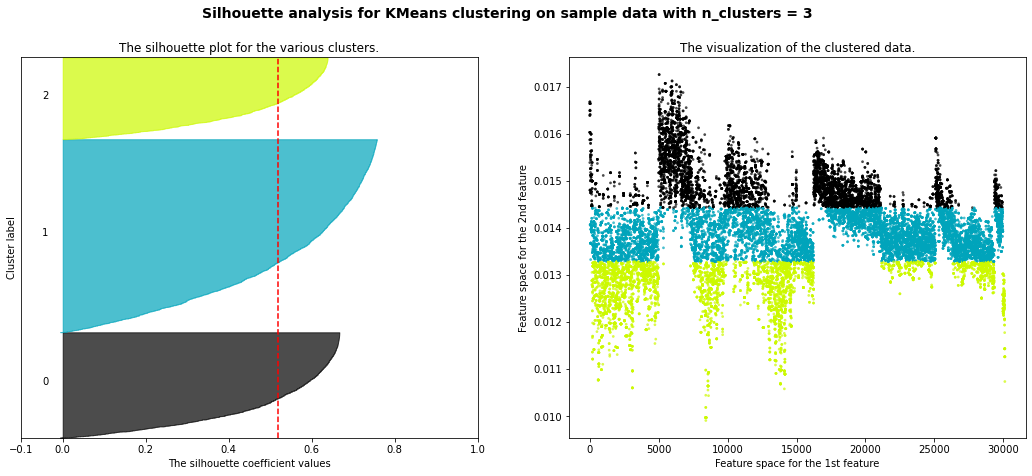

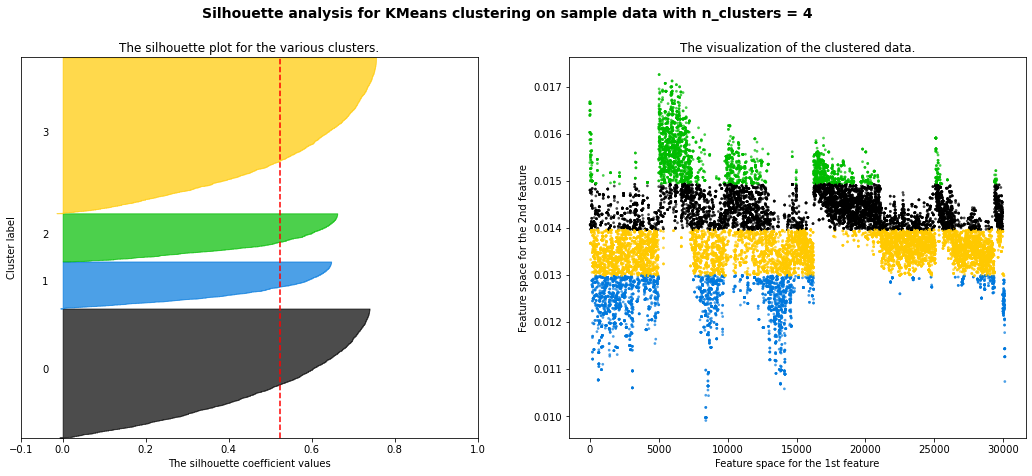

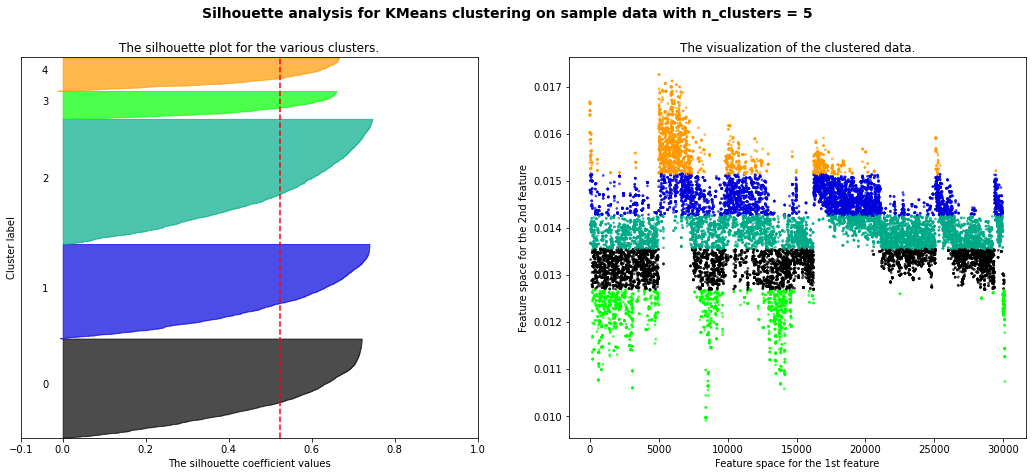

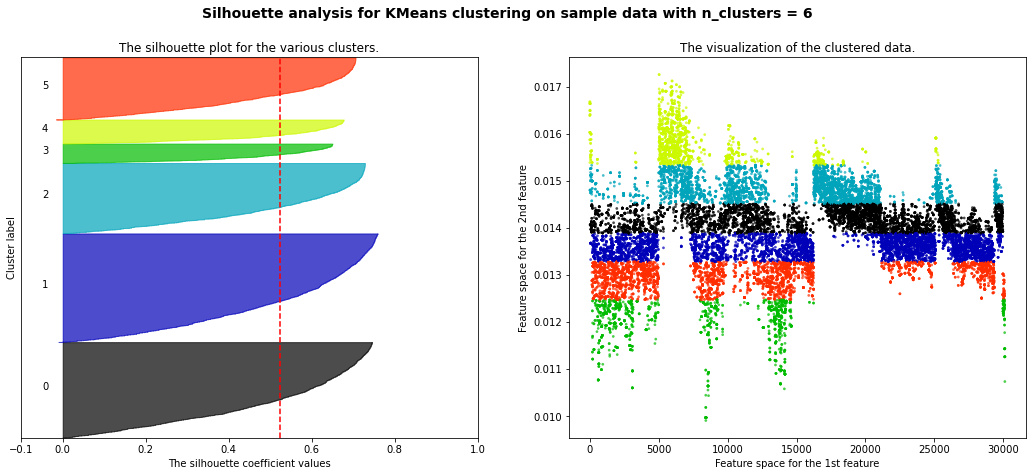

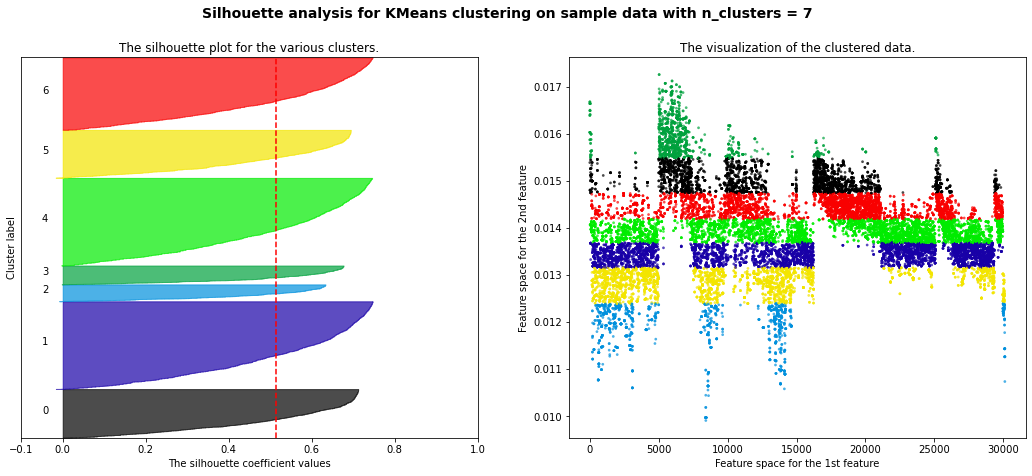

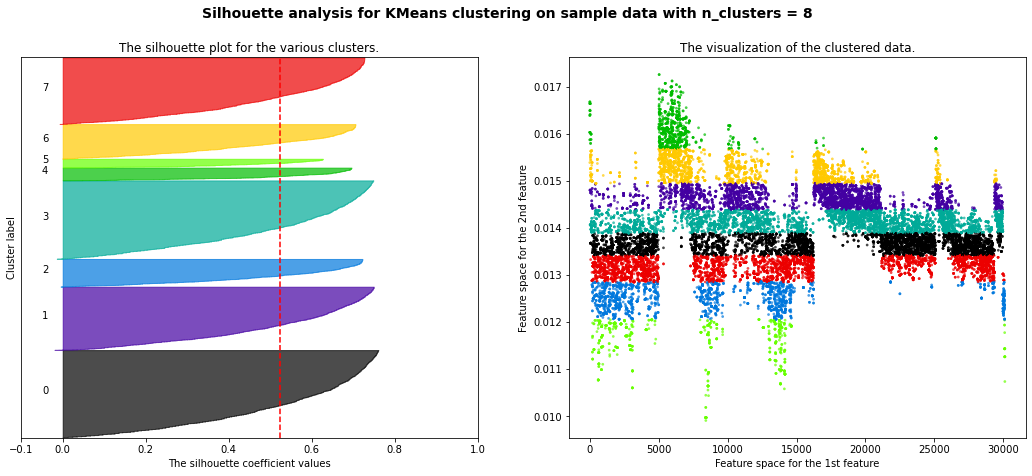

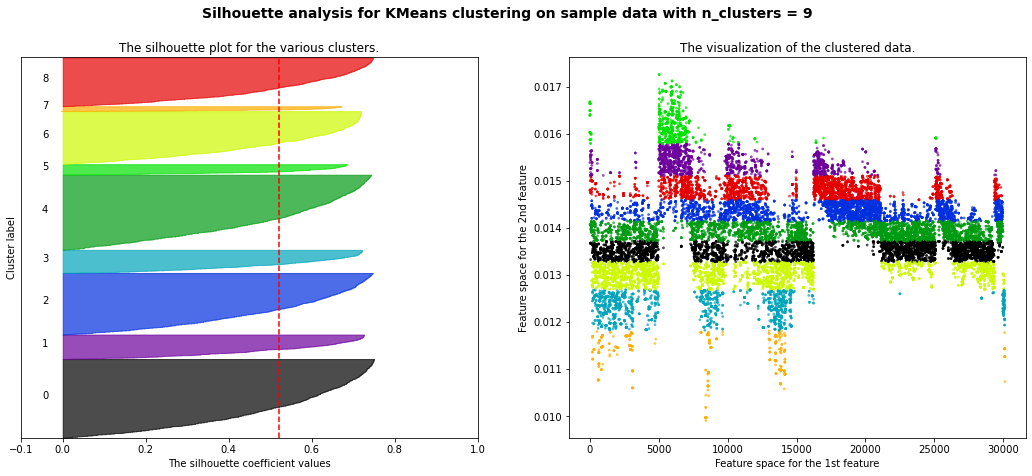

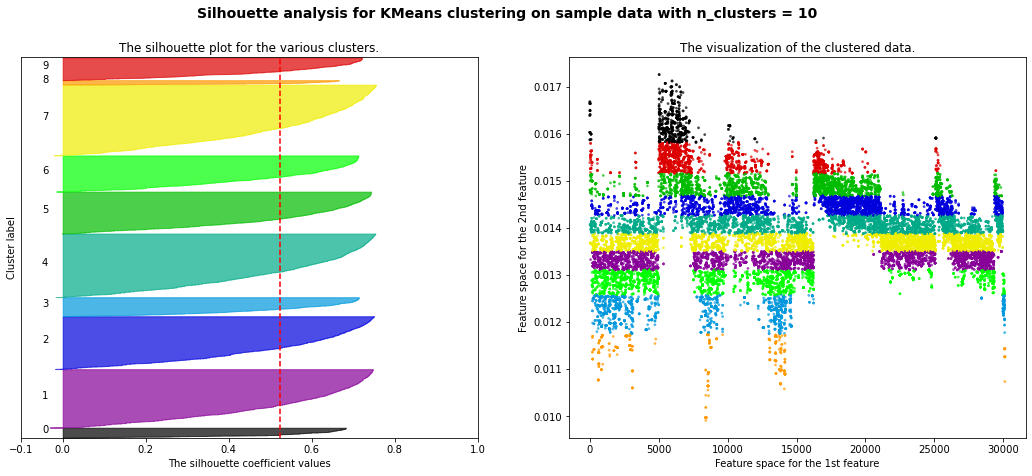

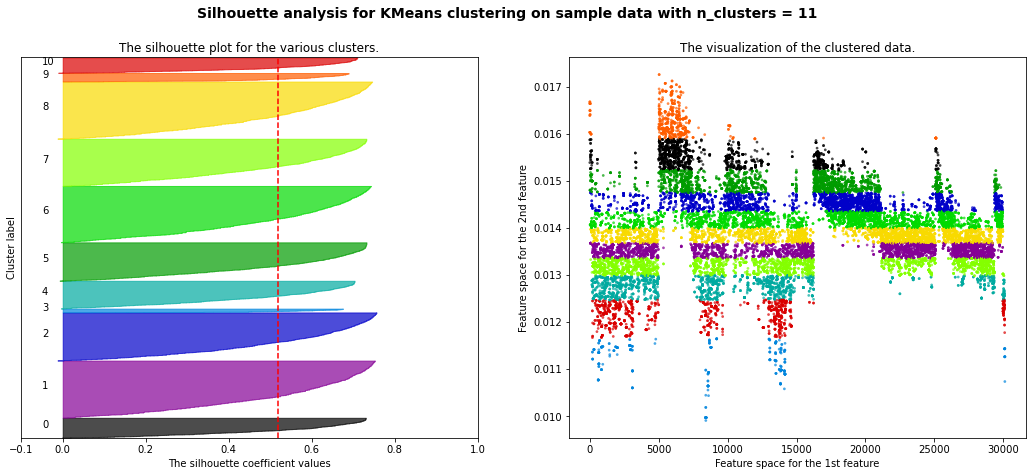

In [12]:
# Combine all trials into one DF
domingo_overall_cb = pd.concat([CB_RMS_OVERALL_B1, CB_RMS_OVERALL_B2, CB_RMS_OVERALL_B3,
                           CB_RMS_OVERALL_A1, CB_RMS_OVERALL_A2, CB_RMS_OVERALL_A3, CB_RMS_OVERALL_A4, CB_RMS_OVERALL_A5])
domingo_overall_cb = domingo_overall_cb.rename(columns={'Value': 'FFT'})
domingo_overall_cb = domingo_overall_cb.reset_index(drop=True)
display(domingo_overall_cb)

controlled_rms_cluster_df = domingo_overall_cb.drop(columns=['Time'])
controlled_rms_cluster_df = pd.get_dummies(controlled_rms_cluster_df)
controlled_rms_cluster_df['stiffener kit'] = controlled_rms_cluster_df['stiffener kit'].astype(int)
display(controlled_rms_cluster_df.head())

controlled_rms_cluster_data = controlled_rms_cluster_df.to_numpy()

# Normalize RMS and pressure
controlled_rms_cluster_data[:, :2] = min_max_norm(controlled_rms_cluster_data[:, :2])
print(controlled_rms_cluster_data)

# Perform clustering
# controlled_rms_best_clustering = silhouette_cluster_analysis(controlled_rms_cluster_data, controlled_rms_cluster_df)
controlled_rms_best_clustering = silhouette_cluster_analysis(controlled_rms_cluster_data[:, :1], controlled_rms_cluster_df, 'kmeans')

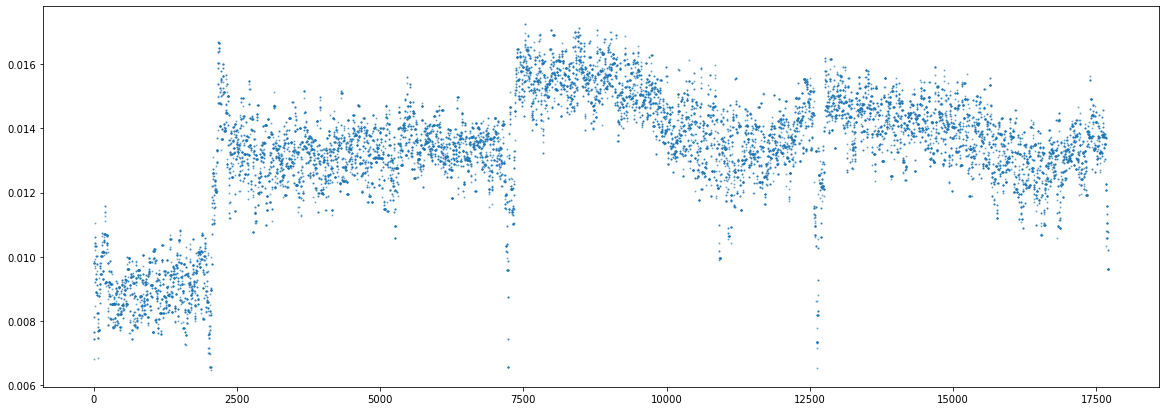

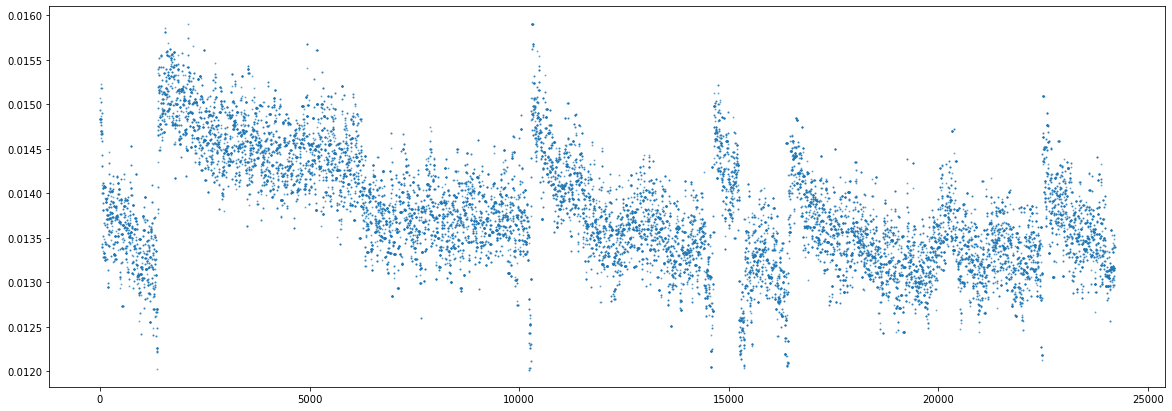

C:\Users\camer\anaconda3\envs\general\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\camer\anaconda3\envs\general\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'RMS')

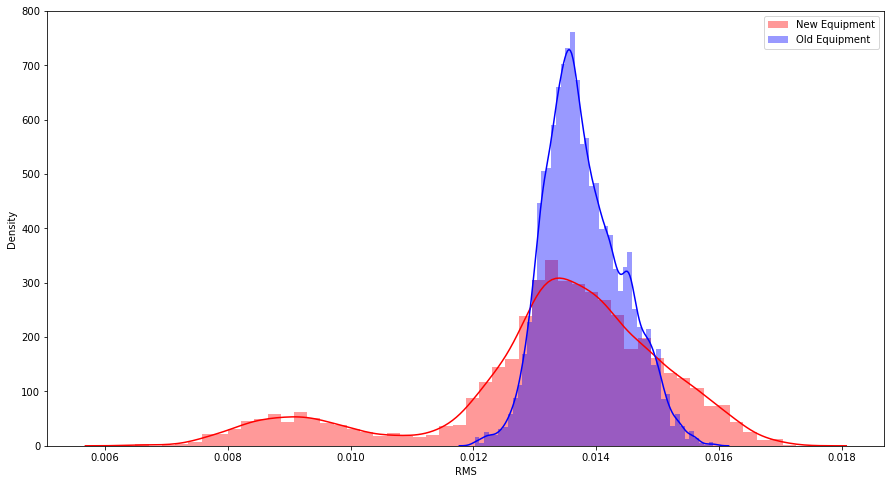

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import display
import seaborn as sns

oct_overall = pd.read_csv('data/diego-controlled-runs/grafana_data_export oct_overall.csv', sep=';', engine='python', header=1)
oct_overall = oct_overall[oct_overall['Series'] == 'CB Bond Vibration'].reset_index(drop=True)
oct_overall_cb = oct_overall.drop(columns='Series')

df = oct_overall_cb.drop(np.arange(50000, 115000))
df = df.reset_index(drop=True)

df = df.drop(np.arange(97000, max(df.index)))
df = df.reset_index(drop=True)

df = df.drop(np.arange(32000, 40000))
df = df.reset_index(drop=True)

oct_overall_cb_new = df.iloc[:45000]
oct_overall_cb_new = oct_overall_cb_new[oct_overall_cb_new.Value > 0.006]
oct_overall_cb_new = oct_overall_cb_new.reset_index(drop=True)

figure(figsize=(20,7))
plt.scatter(oct_overall_cb_new.index, oct_overall_cb_new.Value, s=1, alpha=.5)
plt.show()

oct_overall_cb_old = df.iloc[45000:]
oct_overall_cb_old = oct_overall_cb_old[oct_overall_cb_old.Value > 0.012]
oct_overall_cb_old = oct_overall_cb_old.reset_index(drop=True)

figure(figsize=(20,7))
plt.scatter(oct_overall_cb_old.index, oct_overall_cb_old.Value, s=1, alpha=.5)
plt.show()

# KDE Plot
figure(figsize=(15,8))

sns.distplot(oct_overall_cb_new.Value, color='r', label='New Equipment')
sns.distplot(oct_overall_cb_old.Value, color='b', label='Old Equipment')
plt.legend()
plt.xlabel('RMS')
plt.show()

The motif is located at index 2537
The nearest neighbor is located at index 1337
The discord is located at index 4355
The nearest neighbor subsequence to this discord is 26.139314949152762 units away


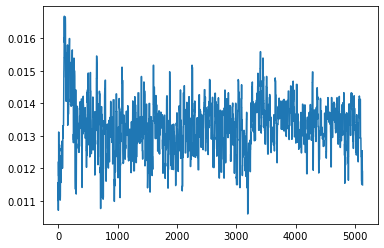

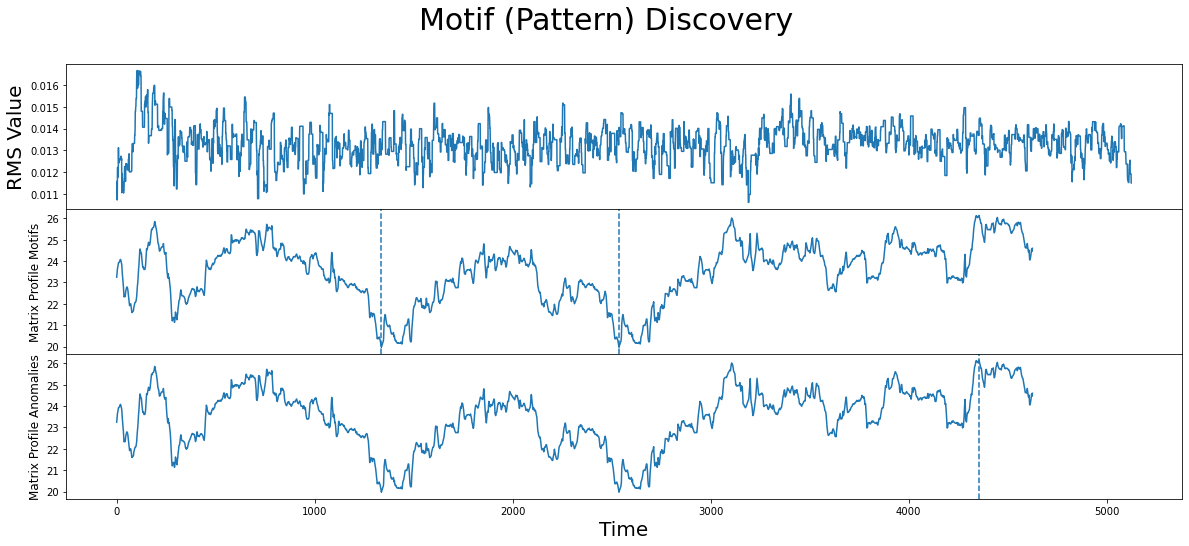

In [46]:
import stumpy
from matplotlib.patches import Rectangle

oct_overall_cb_new = df.iloc[11600:16725]
oct_overall_cb_new = oct_overall_cb_new.reset_index(drop=True)

plt.plot(oct_overall_cb_new.Value)

# Find Motifs
m = 500
mp = stumpy.stump(oct_overall_cb_new.Value, m)

motif_idx = np.argsort(mp[:, 0])[0]
print(f"The motif is located at index {motif_idx}")

nearest_neighbor_idx = mp[motif_idx, 1]
print(f"The nearest neighbor is located at index {nearest_neighbor_idx}")

discord_idx = np.argsort(mp[:, 0])[-1]
print(f"The discord is located at index {discord_idx}")

nearest_neighbor_distance = mp[discord_idx, 0]
print(f"The nearest neighbor subsequence to this discord is {nearest_neighbor_distance} units away")

fig, axs = plt.subplots(3, sharex=True, sharey=False, gridspec_kw={'hspace': 0}, figsize=(20, 8))
plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

axs[0].plot(oct_overall_cb_new.Value)
axs[0].set_ylabel('RMS Value', fontsize='20')
# rect = Rectangle((motif_idx, 0), m, 40, facecolor='lightgrey')
# axs[0].add_patch(rect)
# rect = Rectangle((nearest_neighbor_idx, 0), m, 40, facecolor='lightgrey')
# axs[0].add_patch(rect)

axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile Motifs', fontsize='12')
axs[1].axvline(x=motif_idx, linestyle="dashed")
axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed")
axs[1].plot(mp[:, 0])

axs[2].set_xlabel('Time', fontsize ='20')
axs[2].set_ylabel('Matrix Profile Anomalies', fontsize='12')
axs[2].axvline(x=discord_idx, linestyle="dashed")
axs[2].plot(mp[:, 0])
plt.show()
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256924 entries, 0 to 256923
Data columns (total 23 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   time                           256924 non-null  datetime64[ns]
 1   Bonding Roll Actual Velocity   256924 non-null  float64       
 2   Bonding Roll Command Velocity  256924 non-null  float64       
 3   Bonding Roll Position Error    256924 non-null  float64       
 4   Bonding Roll Torque            256924 non-null  float64       
 5   Continuous Bond FFT Band 0     256924 non-null  float64       
 6   Continuous Bond FFT Band 1     256924 non-null  float64       
 7   Continuous Bond FFT Band 2     256924 non-null  float64       
 8   Continuous Bond FFT Band 3     256924 non-null  float64       
 9   Continuous Bond FFT Band 4     256924 non-null  float64       
 10  Continuous Bond FFT Band 5     256924 non-null  float64       
 11  

None

Bonding Roll Actual Velocity  Bonding Roll Command Velocity  \
0                     19.991970                           20.0   
1                     19.992474                           20.0   
2                     19.991299                           20.0   
3                     19.994594                           20.0   
4                     19.993358                           20.0   

   Bonding Roll Position Error  Bonding Roll Torque  \
0                    -0.000125             22.77375   
1                     0.000020             23.18375   
2                    -0.000086             22.76125   
3                     0.000019             21.94625   
4                    -0.000044             22.95750   

   Continuous Bond FFT Band 0  Continuous Bond FFT Band 1  \
0                    0.045374                    0.060106   
1                    0.054046                    0.069055   
2                    0.048100                    0.058773   
3                    0.043241                    0.048208   
4                    0.047849                    0.061288   

   Continuous Bond FFT Band 2  Continuous Bond FFT Band 3  \
0                    0.086169                    0.177121   
1                    0.098884                    0.181853   
2                    0.074450                    0.178567   
3                    0.060197                    0.181145   
4                    0.077711                    0.154665   

   Continuous Bond FFT Band 4  Continuous Bond FFT Band 5  ...  \
0                    0.017668                    0.018142  ...   
1                    0.015801                    0.017290  ...   
2                    0.018121                    0.021072  ...   
3                    0.023709                    0.021157  ...   
4                    0.016706                    0.016763  ...   

   Continuous Bond Vibration  Tackdown Bond Vibration  Tackdown FFT Band 0  \
0                   0.752660                 0.156966             0.011627   
1                   0.753309                 0.142986             0.011662   
2                   0.731111                 0.139756             0.011648   
3                   0.726999                 0.136275             0.011583   
4                   0.714314                 0.145470             0.011519   

   Tackdown FFT Band 1  Tackdown FFT Band 2  Tackdown FFT Band 3  \
0             0.014335             0.015788             0.017352   
1             0.014295             0.015707             0.017342   
2             0.014566             0.015601             0.017063   
3             0.014761             0.015673             0.017040   
4             0.014665             0.015660             0.017488   

   Tackdown FFT Band 4  Tackdown FFT Band 5  Tackdown FFT Band 6  \
0             0.008325             0.007435             0.006408   
1             0.008298             0.007430             0.006358   
2             0.008236             0.007385             0.006348   
3             0.008113             0.007296             0.006343   
4             0.008072             0.007338             0.006396   

   Tackdown FFT Band 7  
0             0.006525  
1             0.006489  
2             0.006415  
3             0.006354  
4             0.006462  

[5 rows x 22 columns]

C:\Users\camer\Anaconda3\envs\school\lib\site-packages\numba\cuda\compiler.py:726: NumbaPerformanceWarning: Grid size (13) < 2 * SM count (160) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
C:\Users\camer\Anaconda3\envs\school\lib\site-packages\numba\cuda\compiler.py:726: NumbaPerformanceWarning: Grid size (13) < 2 * SM count (160) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
C:\Users\camer\Anaconda3\envs\school\lib\site-packages\numba\cuda\compiler.py:726: NumbaPerformanceWarning: Grid size (13) < 2 * SM count (160) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
C:\Users\camer\Anaconda3\envs\school\lib\site-packages\numba\cuda\compiler.py:726: NumbaPerformanceWarning: Grid size (13) < 2 * SM count (160) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
C:\Users\cam

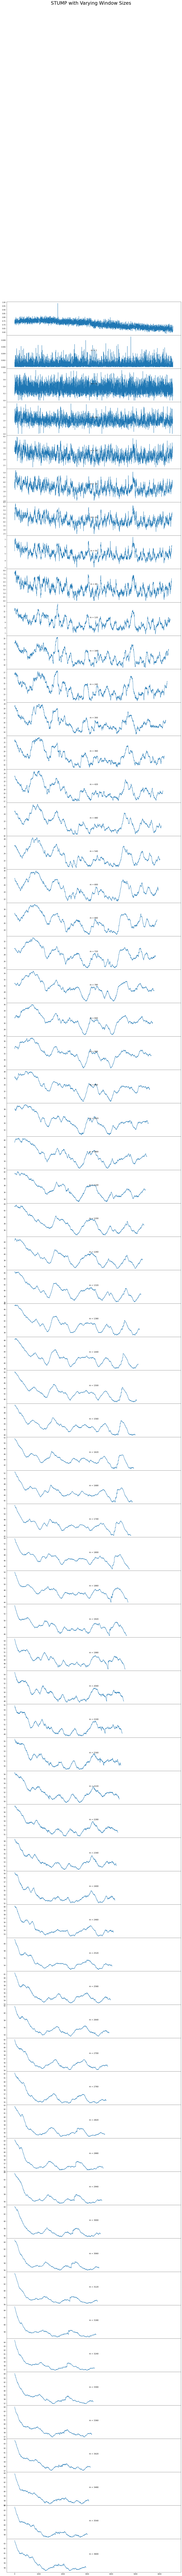

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import display
import stumpy
import numpy as np

# 2022-01-31T14:00:00.007455
jan31 = pd.read_csv("data/Jan_31_Data/31JAN2022_2Pto4P_pivoted.csv")
jan31.time = pd.to_datetime(jan31.time, format='%Y-%m-%dT%H:%M:%S.%f')
display(jan31.info())

jan31 = jan31.set_index('time')
tmp_df = jan31.groupby(by=[jan31.index.hour, jan31.index.minute, jan31.index.second]).agg('mean').reset_index(drop=True)
display(tmp_df.head())

windows = np.concatenate((np.array([3, 6, 10, 20, 30, 40, 50]), 
                         np.arange(60, 60*60+1, 60)))

fig, axs = plt.subplots(len(windows)+1, sharex=True, sharey=False, gridspec_kw={'hspace': 0}, figsize=(20,len(windows)*4))
axs[0].plot(tmp_df['Continuous Bond Vibration'])
# fig.text(0.5, -0.1, 'Subsequence Start Date', ha='center')
# fig.text(0.08, 0.5, 'Matrix Profile', va='center', rotation='vertical')
for i, varying_m in enumerate(windows):
    i += 1
    mp = stumpy.gpu_stump(tmp_df['Continuous Bond Vibration'], varying_m)
    axs[i].plot(mp[:, 0])
    # axs[i].set_ylim(0,9.5)
    # axs[i].set_xlim(0,3600)
    title = f"m = {varying_m}"
    axs[i].set_title(title, y=.5)
# plt.xticks(np.arange(0, taxi_df.shape[0], (48*DAY_MULTIPLIER)/2), x_axis_labels)
# plt.xticks(jan31.time)
# plt.xticks(rotation=75)
plt.suptitle('STUMP with Varying Window Sizes', fontsize='30')
plt.show()

Index(['Bonding Roll Actual Velocity', 'Bonding Roll Command Velocity',
       'Bonding Roll Position Error', 'Bonding Roll Torque',
       'Continuous Bond FFT Band 0', 'Continuous Bond FFT Band 1',
       'Continuous Bond FFT Band 2', 'Continuous Bond FFT Band 3',
       'Continuous Bond FFT Band 4', 'Continuous Bond FFT Band 5',
       'Continuous Bond FFT Band 6', 'Continuous Bond FFT Band 7',
       'Continuous Bond Vibration', 'Tackdown Bond Vibration',
       'Tackdown FFT Band 0', 'Tackdown FFT Band 1', 'Tackdown FFT Band 2',
       'Tackdown FFT Band 3', 'Tackdown FFT Band 4', 'Tackdown FFT Band 5',
       'Tackdown FFT Band 6', 'Tackdown FFT Band 7'],
      dtype='object')
kpca explained variance ratio: [0.58271619 0.18125522 0.05254283 0.04445341 0.03144568 0.03021616
 0.02343114 0.01511043 0.01359224 0.0128933  0.01005073 0.00229269]
1.0000000000000002


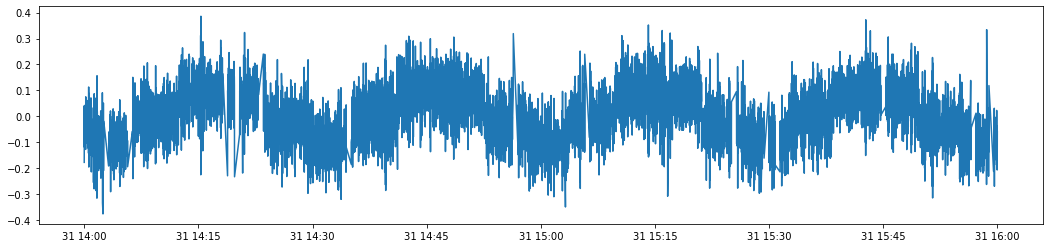

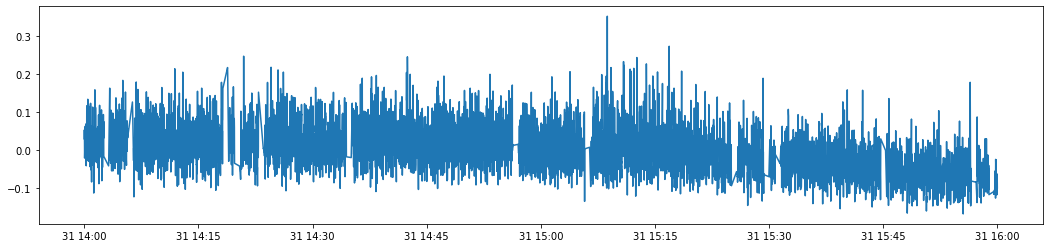

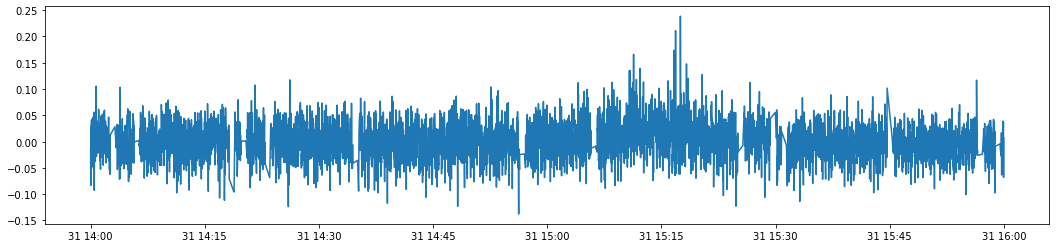

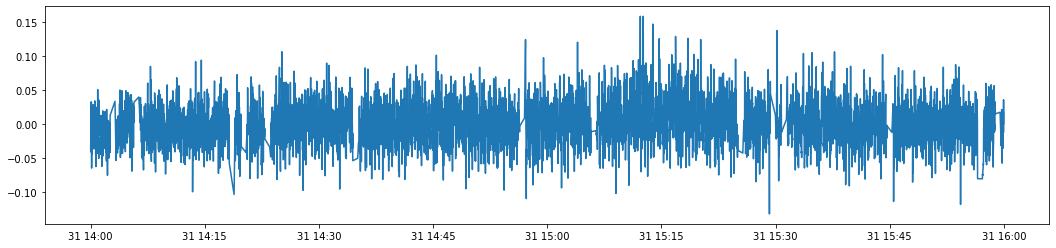

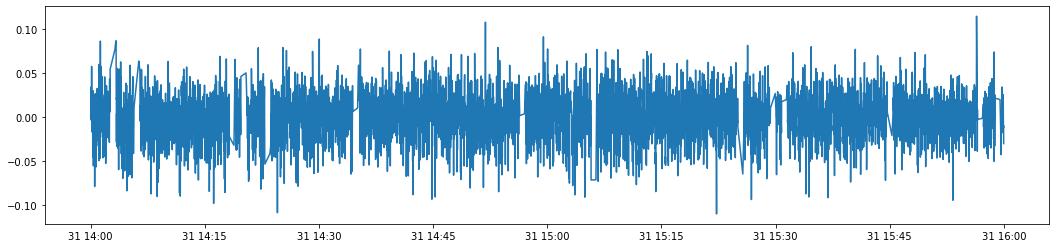

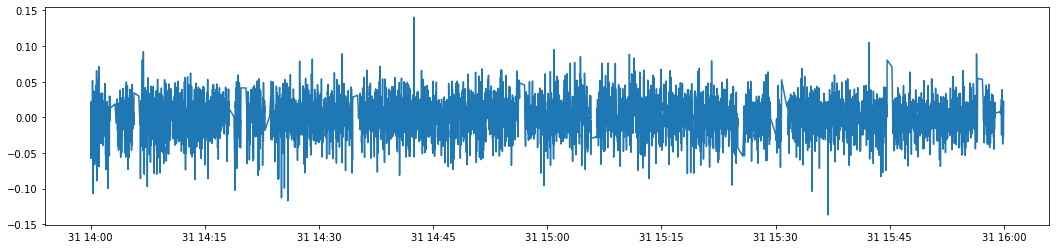

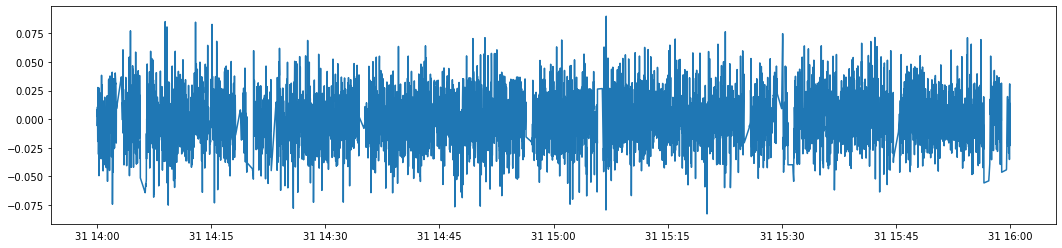

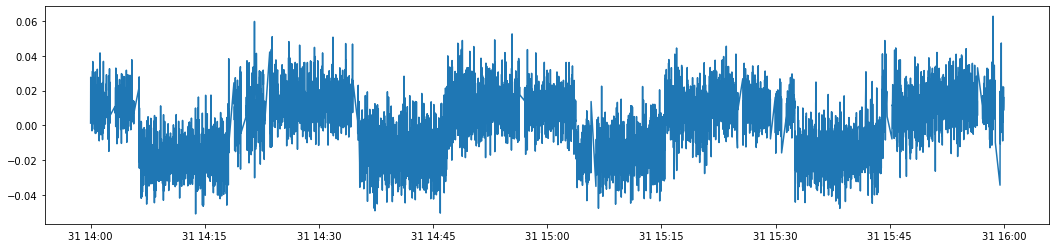

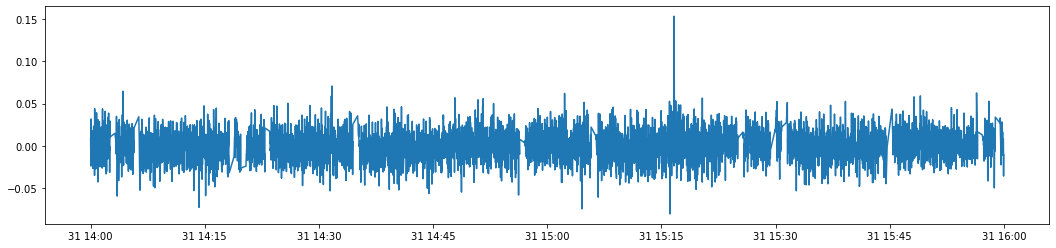

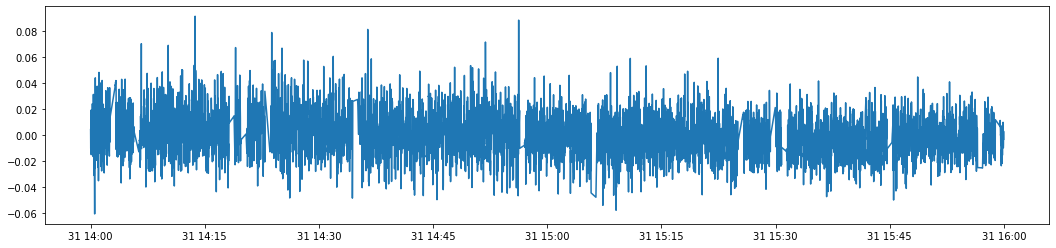

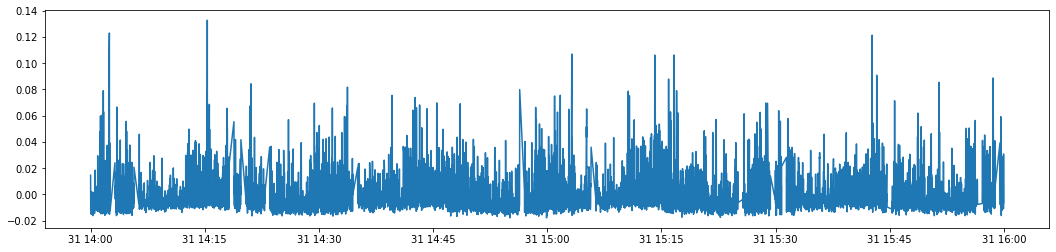

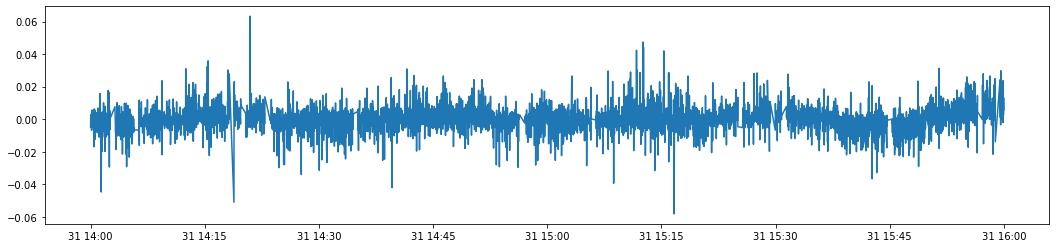

AttributeError: 'int' object has no attribute 'replace'

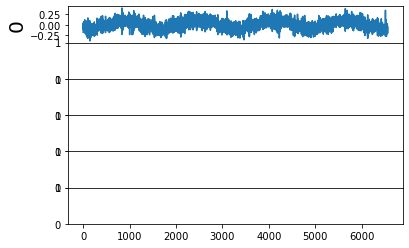

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import display
import stumpy
import numpy as np
from sklearn.decomposition import PCA, FactorAnalysis, KernelPCA

np.set_printoptions(suppress=True)

jan31 = pd.read_csv("data/Jan_31_Data/31JAN2022_2Pto4P_pivoted.csv")
jan31.time = pd.to_datetime(jan31.time, format='%Y-%m-%dT%H:%M:%S.%f')
jan31 = jan31.set_index('time')

print(jan31.columns)
jan31 = jan31.iloc[:, :12] # Keep only continuous bond FFT values (dropping overall RMS)

jan31_data = jan31.to_numpy()

jan31_by_second_data_df = jan31.groupby(by=[jan31.index.year, jan31.index.month, jan31.index.day, jan31.index.hour, jan31.index.minute, jan31.index.second]).agg('mean')
jan31_by_second_data_df.index = pd.to_datetime(jan31_by_second_data_df.index.get_level_values(0).astype(str) + '-' +
               jan31_by_second_data_df.index.get_level_values(1).astype(str) + '-' +
               jan31_by_second_data_df.index.get_level_values(2).astype(str) + 'T' +
               jan31_by_second_data_df.index.get_level_values(3).astype(str) + ':' +
               jan31_by_second_data_df.index.get_level_values(4).astype(str) + ':' +
               jan31_by_second_data_df.index.get_level_values(5).astype(str),
               format='%Y-%m-%dT%H:%M:%S')

jan31_by_second_data = jan31_by_second_data_df.to_numpy()
jan31_by_second_data_norm = jan31_by_second_data / jan31_by_second_data.max(axis=0)

n_components = jan31.shape[1]

# jan31_norm = jan31_data / jan31_data.max(axis=0)

# pca = PCA(n_components=n_components)
# jan31_pca = pca.fit_transform(jan31_by_second_data_norm)
# print("PCA explained variance ratio: {}".format(pca.explained_variance_ratio_))
# print(np.sum(pca.explained_variance_ratio_[:n_components])) # First n principle components
# for i in range(n_components):
#     plt.scatter(jan31_by_second_data_df.index, jan31_pca[:, i], s=5, alpha=.5)
#     plt.title('PCA Principle Component %d' % i)
#     plt.xticks(rotation=45)
#     plt.show()


kpca = KernelPCA(n_components=n_components,
                 kernel='rbf')
jan31_kpca = kpca.fit_transform(jan31_by_second_data_norm)
print("kpca explained variance ratio: {}".format(kpca.lambdas_ / np.sum(kpca.lambdas_)))
print(np.sum((kpca.lambdas_ / np.sum(kpca.lambdas_))[:n_components])) # First n principle components

# windows = np.concatenate((np.array([20, 30, 40, 50]), np.arange(60, 60*10+1, 60)))
windows = np.arange(60, 60*20+1, 60) # From one minute to twenty minutes

for i in range(n_components):

    figure(figsize=(18,4))
    plt.plot(jan31_by_second_data_df.index, jan31_kpca[:, i])
    plt.show()

    # fig, axs = plt.subplots(windows.shape[0], sharex=True, sharey=False, gridspec_kw={'hspace': 0}, figsize=(18,windows.shape[0]*3))
    # for j, varying_m in enumerate(windows):
    #     mp = stumpy.stump(jan31_kpca[:, i], varying_m)
    #     axs[j].plot(mp[:, 0])
    #     title = f"m = {varying_m}"
    #     axs[j].set_title(title, y=.5)
    # plt.show()

mps, indices = stumpy.mstump(jan31_kpca[:, :3].T, varying_m)
motifs_idx = np.argsort(mps, axis=1)[:, 0]
nn_idx = indices[np.arange(len(motifs_idx)), motifs_idx]

fig, axs = plt.subplots(mps.shape[0] * 2, sharex=True, gridspec_kw={'hspace': 0})

df = pd.DataFrame(data=jan31_kpca[:, :3])

for k, dim_name in enumerate(df.columns):
    axs[k].set_ylabel(dim_name, fontsize='20')
    axs[k].plot(df[dim_name])
    axs[k].set_xlabel('Time', fontsize ='20')

    axs[k + mps.shape[0]].set_ylabel(dim_name.replace('T', 'P'), fontsize='20')
    axs[k + mps.shape[0]].plot(mps[k], c='orange')
    axs[k + mps.shape[0]].set_xlabel('Time', fontsize ='20')

    axs[k].axvline(x=motifs_idx[1], linestyle="dashed", c='black')
    axs[k].axvline(x=nn_idx[1], linestyle="dashed", c='black')
    axs[k + mps.shape[0]].axvline(x=motifs_idx[1], linestyle="dashed", c='black')
    axs[k + mps.shape[0]].axvline(x=nn_idx[1], linestyle="dashed", c='black')

    if dim_name != 'T3':
        axs[k].plot(range(motifs_idx[k], motifs_idx[k] + m), df[dim_name].iloc[motifs_idx[k] : motifs_idx[k] + m], c='red', linewidth=4)
        axs[k].plot(range(nn_idx[k], nn_idx[k] + m), df[dim_name].iloc[nn_idx[k] : nn_idx[k] + m], c='red', linewidth=4)
        axs[k + mps.shape[0]].plot(motifs_idx[k], mps[k, motifs_idx[k]] + 1, marker="v", markersize=10, color='red')
        axs[k + mps.shape[0]].plot(nn_idx[k], mps[k, nn_idx[k]] + 1, marker="v", markersize=10, color='red')
    else:
        axs[k + mps.shape[0]].plot(motifs_idx[k], mps[k, motifs_idx[k]] + 1, marker="v", markersize=10, color='black')
        axs[k + mps.shape[0]].plot(nn_idx[k], mps[k, nn_idx[k]] + 1, marker="v", markersize=10, color='black')

plt.show()


In [5]:
import numba.cuda.api,numba.cuda.cudadrv.libs
numba.cuda.cudadrv.libs.test()
numba.cuda.api.detect()

Finding nvvm from Conda environment
	located at C:\Users\camer\Anaconda3\envs\school\Library\bin\nvvm64_40_0.dll
	trying to open library...	ok
Finding cudart from Conda environment
	located at C:\Users\camer\Anaconda3\envs\school\Library\bin\cudart64_110.dll
	trying to open library...	ok
Finding cudadevrt from Conda environment
	located at C:\Users\camer\Anaconda3\envs\school\Library\bin\cudadevrt.lib
Finding libdevice from Conda environment
	searching for compute_20...	ok
	searching for compute_30...	ok
	searching for compute_35...	ok
	searching for compute_50...	ok
Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 3080 Ti'                              [SUPPORTED]
                      Compute Capability: 8.6
                           PCI Device ID: 0
                              PCI Bus ID: 45
                                    UUID: GPU-d3d85f33-f16c-cb71-8e80-33de3e7d1a0e
                                Watchdog: Enabled
                            Compute Mode: WDDM
           

True